In [2]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os

In [3]:
percolator_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/percolator_df.pkl')

In [4]:
percolator_df.columns

Index(['file_idx', 'scan', 'charge_x', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa', 'feature_id', 'charge_y',
       'rt_apex', 'scan_apex', 'intensity', 'precursor_id',
       'monoisotopic_mass', 'predicted_mass_error',
       'recalibrated_monoisotopic_mass', 'recalibrated_monoisotopic_mz',
       'percolator_idx', 'batch', 'human'],
      dtype='object')

In [8]:
# find the experiment-average for each sequence-charge
experiment_sequences_l = []
for group_name,group_df in percolator_df.groupby(['sequence','charge_x'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    theoretical_mz = group_df.iloc[0]['spectrum precursor m/z']
    experiment_average_scan = group_df.scan_apex.mean()
    experiment_average_rt = group_df.rt_apex.mean()
    experiment_sequences_l.append((sequence, charge, theoretical_mz, experiment_average_scan, experiment_average_rt))

In [10]:
experiment_sequences_df = pd.DataFrame(experiment_sequences_l, columns=['sequence','charge','theoretical_mz', 'experiment_average_scan', 'experiment_average_rt'])

In [11]:
experiment_sequences_df.head()

,sequence,charge,theoretical_mz,experiment_average_scan,experiment_average_rt
0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.1049,73.528889,604.371111
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,789.7394,336.016667,609.890000
2,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.0286,159.998000,489.613333
3,AAAAALSQQQSLQER,2,785.9075,496.325000,375.042500
4,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,864.1171,706.957407,1039.716667


In [9]:
run_sequences_l = []
for group_name,group_df in percolator_df.groupby(['file_idx','sequence','charge_x'], as_index=False):
    file_idx = group_name[0]
    sequence = group_name[1]
    charge = group_name[2]
    run_average_mz = group_df.recalibrated_monoisotopic_mz.mean()
    run_average_scan = group_df.scan_apex.mean()
    run_average_rt = group_df.rt_apex.mean()
    run_sequences_l.append((file_idx,sequence,charge,run_average_mz,run_average_scan,run_average_rt))

In [12]:
run_sequences_df = pd.DataFrame(run_sequences_l, columns=['file_idx','sequence','charge','run_average_mz','run_average_scan','run_average_rt'])

In [13]:
run_sequences_df.head()

,file_idx,sequence,charge,run_average_mz,run_average_scan,run_average_rt
0,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608396,74.015000,601.575
1,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532319,156.406667,486.690
2,0,AAAAAWEEPSSGNGTAR,2,823.382064,535.310000,367.240
3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,892.112987,468.100000,997.180
4,0,AAAEDVNVTFEDQQK,2,832.891998,485.630000,471.790


In [14]:
merged_df = pd.merge(run_sequences_df, experiment_sequences_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])

In [15]:
merged_df.head()

,file_idx,sequence,charge,run_average_mz,run_average_scan,run_average_rt,theoretical_mz,experiment_average_scan,experiment_average_rt
0,0,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1184.608396,74.015000,601.575,1184.1049,73.528889,604.371111
1,0,AAAAAAAAVPSAGPAGPAPTSAAGR,2,1016.532319,156.406667,486.690,1016.0286,159.998000,489.613333
2,0,AAAAAWEEPSSGNGTAR,2,823.382064,535.310000,367.240,822.8783,532.994286,371.006190
3,0,AAAAPVTGPLADDPIQETITFDDFAK,3,892.112987,468.100000,997.180,891.7775,465.181500,997.738000
4,0,AAAEDVNVTFEDQQK,2,832.891998,485.630000,471.790,832.3878,486.112727,474.475455


Extract the training set for file_idx = 0

In [22]:
X_df = merged_df[merged_df.file_idx == 0][['theoretical_mz','experiment_average_scan','experiment_average_rt']]
y_df = merged_df[merged_df.file_idx == 0][['run_average_mz','run_average_scan','run_average_rt']]

In [29]:
X = X_df.values
y = y_df.values

In [26]:
from sklearn import preprocessing

In [27]:
min_max_scaler = preprocessing.MinMaxScaler()

In [30]:
X_scaled = min_max_scaler.fit_transform(X)

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X_scaled, y, test_size=0.3)

In [34]:
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5)

In [37]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(9697, 3) (2078, 3) (2078, 3) (9697, 3) (2078, 3) (2078, 3)


In [23]:
from keras.models import Model
from keras.layers import Input, Dense

Using TensorFlow backend.


In [24]:
inputs = Input(shape=(3,), dtype='float32', name='main_input')

In [53]:
x = Dense(256, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='sigmoid')(x)

In [54]:
model = Model(inputs=inputs, outputs=predictions)

In [55]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [56]:
hist = model.fit(X_train, y_train,
          batch_size=32, epochs=500,
          validation_data=(X_val, y_val))

Train on 9697 samples, validate on 2078 samples
Epoch 1/500
9697/9697 [==============================] - 1s 114us/step - loss: 505090.8411 - acc: 0.1786 - val_loss: 504000.6159 - val_acc: 0.1800
Epoch 2/500
9697/9697 [==============================] - 1s 89us/step - loss: 505088.6580 - acc: 0.1768 - val_loss: 504000.6159 - val_acc: 0.1805
Epoch 3/500
9697/9697 [==============================] - 1s 90us/step - loss: 505088.6592 - acc: 0.1757 - val_loss: 504000.6159 - val_acc: 0.1800
Epoch 4/500
9697/9697 [==============================] - 1s 92us/step - loss: 505088.6558 - acc: 0.1776 - val_loss: 504000.6159 - val_acc: 0.1809
Epoch 5/500
9697/9697 [==============================] - 1s 93us/step - loss: 505088.6570 - acc: 0.1792 - val_loss: 504000.6159 - val_acc: 0.1843
Epoch 6/500
9697/9697 [==============================] - 1s 92us/step - loss: 505088.6581 - acc: 0.1806 - val_loss: 504000.6159 - val_acc: 0.1901
Epoch 7/500
9697/9697 [==============================] - 1s 92us/step - los

9697/9697 [==============================] - 1s 86us/step - loss: 505088.6577 - acc: 0.4492 - val_loss: 504000.6159 - val_acc: 0.4572
Epoch 57/500
9697/9697 [==============================] - 1s 85us/step - loss: 505088.6578 - acc: 0.4499 - val_loss: 504000.6159 - val_acc: 0.4596
Epoch 58/500
9697/9697 [==============================] - 1s 86us/step - loss: 505088.6573 - acc: 0.4501 - val_loss: 504000.6159 - val_acc: 0.4466
Epoch 59/500
9697/9697 [==============================] - 1s 88us/step - loss: 505088.6599 - acc: 0.4541 - val_loss: 504000.6159 - val_acc: 0.4673
Epoch 60/500
9697/9697 [==============================] - 1s 85us/step - loss: 505088.6575 - acc: 0.4583 - val_loss: 504000.6159 - val_acc: 0.4615
Epoch 61/500
9697/9697 [==============================] - 1s 88us/step - loss: 505088.6564 - acc: 0.4517 - val_loss: 504000.6159 - val_acc: 0.4706
Epoch 62/500
9697/9697 [==============================] - 1s 102us/step - loss: 505088.6570 - acc: 0.4580 - val_loss: 504000.6159 -

9697/9697 [==============================] - 1s 78us/step - loss: 505088.6583 - acc: 0.5118 - val_loss: 504000.6159 - val_acc: 0.5217
Epoch 112/500
9697/9697 [==============================] - 1s 78us/step - loss: 505088.6573 - acc: 0.5135 - val_loss: 504000.6159 - val_acc: 0.5125
Epoch 113/500
9697/9697 [==============================] - 1s 86us/step - loss: 505088.6582 - acc: 0.5124 - val_loss: 504000.6159 - val_acc: 0.5245
Epoch 114/500
9697/9697 [==============================] - 1s 104us/step - loss: 505088.6596 - acc: 0.5171 - val_loss: 504000.6159 - val_acc: 0.5173
Epoch 115/500
9697/9697 [==============================] - 1s 78us/step - loss: 505088.6572 - acc: 0.5149 - val_loss: 504000.6159 - val_acc: 0.5245
Epoch 116/500
9697/9697 [==============================] - 1s 77us/step - loss: 505088.6575 - acc: 0.5151 - val_loss: 504000.6159 - val_acc: 0.5149
Epoch 117/500
9697/9697 [==============================] - 1s 81us/step - loss: 505088.6575 - acc: 0.5124 - val_loss: 504000.

9697/9697 [==============================] - 1s 73us/step - loss: 505088.6592 - acc: 0.5349 - val_loss: 504000.6159 - val_acc: 0.5443
Epoch 167/500
9697/9697 [==============================] - 1s 74us/step - loss: 505088.6574 - acc: 0.5359 - val_loss: 504000.6159 - val_acc: 0.5346
Epoch 168/500
9697/9697 [==============================] - 1s 74us/step - loss: 505088.6577 - acc: 0.5353 - val_loss: 504000.6159 - val_acc: 0.5423
Epoch 169/500
9697/9697 [==============================] - 1s 74us/step - loss: 505088.6571 - acc: 0.5375 - val_loss: 504000.6159 - val_acc: 0.5385
Epoch 170/500
9697/9697 [==============================] - 1s 75us/step - loss: 505088.6575 - acc: 0.5373 - val_loss: 504000.6159 - val_acc: 0.5443
Epoch 171/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6573 - acc: 0.5365 - val_loss: 504000.6159 - val_acc: 0.5486
Epoch 172/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6554 - acc: 0.5364 - val_loss: 504000.6

9697/9697 [==============================] - 1s 72us/step - loss: 505088.6568 - acc: 0.5469 - val_loss: 504000.6159 - val_acc: 0.5491
Epoch 222/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6587 - acc: 0.5459 - val_loss: 504000.6159 - val_acc: 0.5496
Epoch 223/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6570 - acc: 0.5461 - val_loss: 504000.6159 - val_acc: 0.5476
Epoch 224/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6604 - acc: 0.5471 - val_loss: 504000.6159 - val_acc: 0.5510
Epoch 225/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6585 - acc: 0.5482 - val_loss: 504000.6159 - val_acc: 0.5529
Epoch 226/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6567 - acc: 0.5460 - val_loss: 504000.6159 - val_acc: 0.5510
Epoch 227/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6555 - acc: 0.5474 - val_loss: 504000.6

9697/9697 [==============================] - 1s 73us/step - loss: 505088.6577 - acc: 0.5530 - val_loss: 504000.6159 - val_acc: 0.5582
Epoch 277/500
9697/9697 [==============================] - 1s 72us/step - loss: 505088.6566 - acc: 0.5519 - val_loss: 504000.6159 - val_acc: 0.5544
Epoch 278/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6563 - acc: 0.5545 - val_loss: 504000.6159 - val_acc: 0.5549
Epoch 279/500
9697/9697 [==============================] - 1s 74us/step - loss: 505088.6571 - acc: 0.5536 - val_loss: 504000.6159 - val_acc: 0.5553
Epoch 280/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6575 - acc: 0.5522 - val_loss: 504000.6159 - val_acc: 0.5549
Epoch 281/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6587 - acc: 0.5539 - val_loss: 504000.6159 - val_acc: 0.5563
Epoch 282/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6570 - acc: 0.5523 - val_loss: 504000.6

9697/9697 [==============================] - 1s 73us/step - loss: 505088.6568 - acc: 0.5577 - val_loss: 504000.6159 - val_acc: 0.5606
Epoch 332/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6561 - acc: 0.5551 - val_loss: 504000.6159 - val_acc: 0.5606
Epoch 333/500
9697/9697 [==============================] - 1s 74us/step - loss: 505088.6580 - acc: 0.5567 - val_loss: 504000.6159 - val_acc: 0.5592
Epoch 334/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6566 - acc: 0.5552 - val_loss: 504000.6159 - val_acc: 0.5597
Epoch 335/500
9697/9697 [==============================] - 1s 74us/step - loss: 505088.6579 - acc: 0.5573 - val_loss: 504000.6159 - val_acc: 0.5606
Epoch 336/500
9697/9697 [==============================] - 1s 72us/step - loss: 505088.6577 - acc: 0.5567 - val_loss: 504000.6159 - val_acc: 0.5573
Epoch 337/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6559 - acc: 0.5562 - val_loss: 504000.6

9697/9697 [==============================] - 1s 74us/step - loss: 505088.6576 - acc: 0.5583 - val_loss: 504000.6159 - val_acc: 0.5553
Epoch 387/500
9697/9697 [==============================] - 1s 74us/step - loss: 505088.6583 - acc: 0.5577 - val_loss: 504000.6159 - val_acc: 0.5630
Epoch 388/500
9697/9697 [==============================] - 1s 74us/step - loss: 505088.6571 - acc: 0.5582 - val_loss: 504000.6159 - val_acc: 0.5606
Epoch 389/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6576 - acc: 0.5597 - val_loss: 504000.6159 - val_acc: 0.5626
Epoch 390/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6564 - acc: 0.5585 - val_loss: 504000.6159 - val_acc: 0.5616
Epoch 391/500
9697/9697 [==============================] - 1s 74us/step - loss: 505088.6563 - acc: 0.5591 - val_loss: 504000.6159 - val_acc: 0.5645
Epoch 392/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6560 - acc: 0.5586 - val_loss: 504000.6

9697/9697 [==============================] - 1s 77us/step - loss: 505088.6573 - acc: 0.5608 - val_loss: 504000.6159 - val_acc: 0.5664
Epoch 442/500
9697/9697 [==============================] - 1s 75us/step - loss: 505088.6576 - acc: 0.5612 - val_loss: 504000.6159 - val_acc: 0.5630
Epoch 443/500
9697/9697 [==============================] - 1s 74us/step - loss: 505088.6559 - acc: 0.5624 - val_loss: 504000.6159 - val_acc: 0.5659
Epoch 444/500
9697/9697 [==============================] - 1s 75us/step - loss: 505088.6549 - acc: 0.5598 - val_loss: 504000.6159 - val_acc: 0.5659
Epoch 445/500
9697/9697 [==============================] - 1s 74us/step - loss: 505088.6570 - acc: 0.5615 - val_loss: 504000.6159 - val_acc: 0.5650
Epoch 446/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6564 - acc: 0.5608 - val_loss: 504000.6159 - val_acc: 0.5650
Epoch 447/500
9697/9697 [==============================] - 1s 73us/step - loss: 505088.6557 - acc: 0.5620 - val_loss: 504000.6

9697/9697 [==============================] - 1s 116us/step - loss: 505088.6583 - acc: 0.5634 - val_loss: 504000.6159 - val_acc: 0.5654
Epoch 497/500
9697/9697 [==============================] - 1s 88us/step - loss: 505088.6577 - acc: 0.5619 - val_loss: 504000.6159 - val_acc: 0.5640
Epoch 498/500
9697/9697 [==============================] - 1s 85us/step - loss: 505088.6598 - acc: 0.5622 - val_loss: 504000.6159 - val_acc: 0.5654
Epoch 499/500
9697/9697 [==============================] - 1s 85us/step - loss: 505088.6566 - acc: 0.5634 - val_loss: 504000.6159 - val_acc: 0.5674
Epoch 500/500
9697/9697 [==============================] - 1s 122us/step - loss: 505088.6585 - acc: 0.5644 - val_loss: 504000.6159 - val_acc: 0.5650


In [57]:
import matplotlib.pyplot as plt

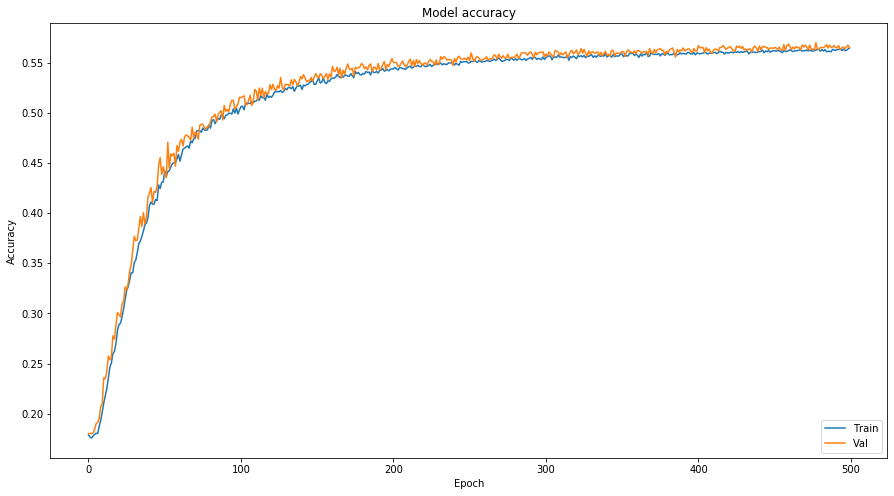

In [58]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()